In [1]:
# ------------------------------------------------------------------------------ #
# @Author:        F. Paul Spitzner
# @Email:         paul.spitzner@ds.mpg.de
# @Created:       2024-05-15 20:53:24
# @Last Modified: 2024-05-15 21:00:21
# ------------------------------------------------------------------------------ #
# This notebook does the model comparison and creates the panel for fig. 2.
# it needs the idata traces from `bayesian_analysis.ipynb`
# Preprocessing / Setup in the first cell is the same in both notebooks.
# ------------------------------------------------------------------------------ #

import os
import pymc as pm
import nutpie
import numpy as np
import pandas as pd
import arviz as az
import sys

import logging

logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

extra_path = os.path.abspath("../")
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph
from ana import bayesian_models as bm

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

data_dir = os.path.abspath("../dat")
data_dir = os.path.abspath("/data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data")

2024-05-21 11:55:39,221 | INFO     | notebook | <module> | project directory: /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code_repo/experiment_analysis


In [12]:
# Lets start with a bit of exploration:
# linear model
idata_lm = az.from_netcdf(f"{data_dir}/bayes_lm_tau_R_natural_movie_three.nc")
# structure group model
idata_sgm = az.from_netcdf(f"{data_dir}/bayes_sgm_tau_R_natural_movie_three.nc")
idata_sgm

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

Warmup iterations saved (warmup_*).

In [3]:
idata_lm

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

Warmup iterations saved (warmup_*).

In [13]:
comparison = az.compare(
    {"linear model": idata_lm, "structure groups": idata_sgm},
)
comparison

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
structure groups,0,-7975.862911,71.579165,0.000000,0.891282,83.809682,0.000000,False,log
linear model,1,-8243.417385,42.871264,267.554474,0.108718,70.499123,29.222643,False,log


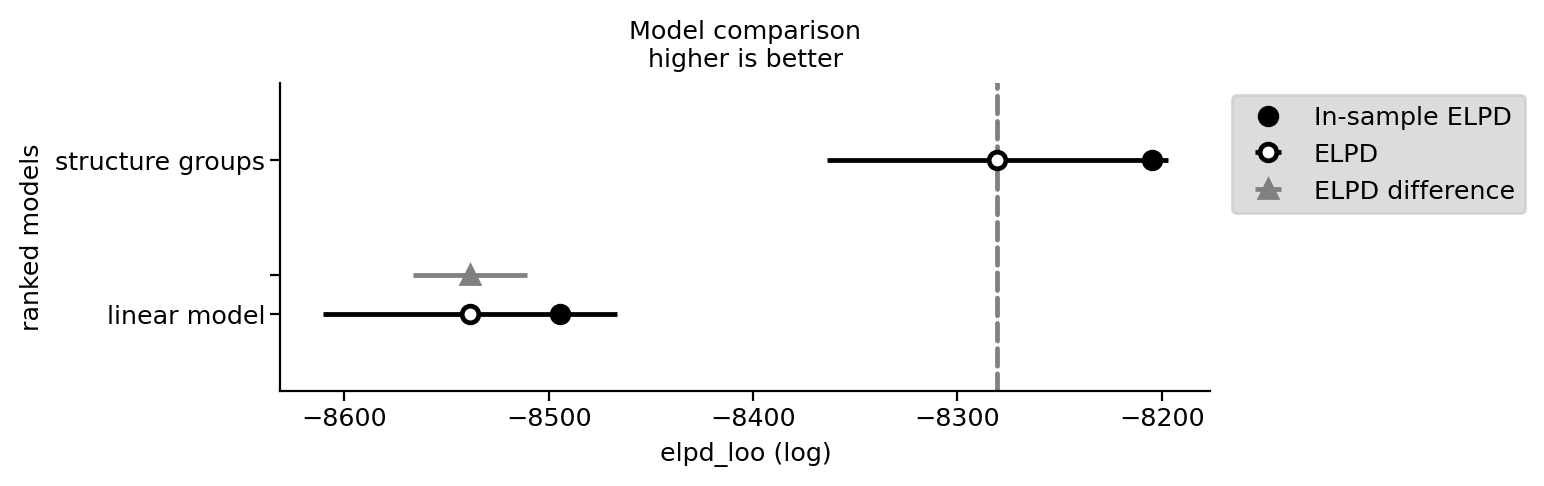

In [5]:
az.plot_compare(comparison, insample_dev=True, plot_ic_diff=True, plot_standard_error=True);

In [6]:
comparison["elpd_loo"]

structure groups   -8280.465612
linear model       -8538.471345
Name: elpd_loo, dtype: float64

In [7]:
loo_lm = az.loo(idata_lm, pointwise=True)
loo_sgm = az.loo(idata_sgm, pointwise=True)

In [8]:
obs = 'loo_i'
print(f"shape: {loo_lm[obs].shape}")
print(f"lm: {np.sum(loo_lm[obs]).values:.1f}")
print(f"sgm: {np.sum(loo_sgm[obs]).values:.1f}")
diff = loo_lm[obs] - loo_sgm[obs]
print(f"diff: {np.sum(diff).values:.1f}")
print(f"se: {np.sqrt(len(diff) * np.var(diff)).values:.1f}")

shape: (6256,)
lm: -8538.5
sgm: -8280.5
diff: -258.0
se: 27.7


In [14]:
# precompute LOO for all models and stimuli

from itertools import product
from tqdm.notebook import tqdm

models = ['sgm', 'lm']
measures = ["tau_double", "tau_R", "R_tot"]
stimuli = ["natural_movie_three", "spontaneous", "natural_movie_one_more_repeats"]

combinations = list(product(measures, stimuli, models))
loos = dict()

for meas, stim, model in tqdm(combinations):
    idata = az.from_netcdf(f"{data_dir}/bayes_{model}_{meas}_{stim}.nc")
    loos[f"{model}_{meas}_{stim}"] = az.loo(idata, pointwise=True)

  0%|          | 0/18 [00:00<?, ?it/s]

stim='natural_movie_three' meas='tau_double', np.sum(diff)=338.62
stim='natural_movie_three' meas='tau_R', np.sum(diff)=267.55
stim='natural_movie_three' meas='R_tot', np.sum(diff)=28.33
stim='spontaneous' meas='tau_double', np.sum(diff)=192.11
stim='spontaneous' meas='tau_R', np.sum(diff)=93.54
stim='spontaneous' meas='R_tot', np.sum(diff)=25.26
stim='natural_movie_one_more_repeats' meas='tau_double', np.sum(diff)=194.65
stim='natural_movie_one_more_repeats' meas='tau_R', np.sum(diff)=136.88
stim='natural_movie_one_more_repeats' meas='R_tot', np.sum(diff)=30.56


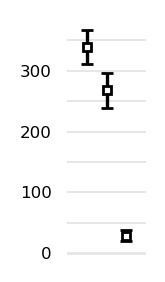

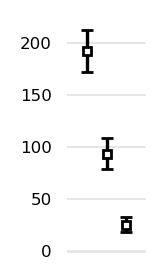

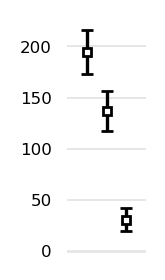

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from bitsandbobs.plt import set_size

matplotlib.rcParams["savefig.facecolor"] = (0.0, 0.0, 0.0, 0.0)  # transparent figure bg
matplotlib.rcParams["axes.facecolor"] = (1.0, 0.0, 0.0, 0.0)
matplotlib.rcParams["xtick.labelsize"]= 6
matplotlib.rcParams["ytick.labelsize"]= 6


# stim = "spontaneous"
# stim = "natural_movie_three"
# stim = "natural_movie_one_more_repeats"

for stim in stimuli:
    _, ax = plt.subplots();
    for mdx, meas in enumerate(measures):
        # this is the same what arviz.compare does, but
        # I decided to not use az.compare because it ranks the models, but we always want
        # to have "structure_groups - linear_model".
        # 'loo_i' gives us the array of the leave-one-out samples, with length rows in df
        diff = (
            loos[f"sgm_{meas}_{stim}"]["loo_i"].values
            - loos[f"lm_{meas}_{stim}"]["loo_i"].values
        )
        ax.errorbar(
            x=mdx + 1,
            y=np.sum(diff),
            yerr=np.sqrt(len(diff) * np.var(diff)),
            label=f"{meas}",
            fmt = "s",
            # markeredgewidth = 0.0,
            markersize = 3.0,
            markerfacecolor = 'white',
            ecolor = 'black',
            color = "black",
            elinewidth = 1.2,
            capsize = 2,
            clip_on=False,
        )
        print(f"{stim=} {meas=}, {np.sum(diff)=:.2f}")

    ax.set_xticks([])
    ax.set_ylim(-5, None)
    # yticks = [25, 20, 15, 10, 5, 0]
    # ax.set_yticks(yticks)
    for y in ax.get_yticks():
        ax.axhline(y, ls="-", lw=1.0 if y == 0 else 0.7, zorder=0, color="#E6E6E6")
    ax.set_xlim(0, 4)
    sns.despine(ax=ax, trim=False, bottom=True)
    # ax.set_ylabel("ELPD difference")
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks_position('none')

    set_size(ax, w=1.0, h=3.0, b=0.1, l=0.7, t=0.1)
    # ax.get_figure().savefig(f"../img/model_comparison_{stim}_all_measures.pdf")

In [ ]:
%load_ext watermark
%watermark -v --iversions --packages nutpie,pymc,arviz